# Logistic regression from scratch
Implementation of clasic logistic regression for binary class clasification

In [62]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

%matplotlib inline

### Prepare dummy datset

In [63]:
data = np.genfromtxt('/nfs/team292/kt22/misc/nn_course/data/toydata.txt',
                     delimiter = '\t')

x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]

### Normalize data

In [64]:
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

### Plot data

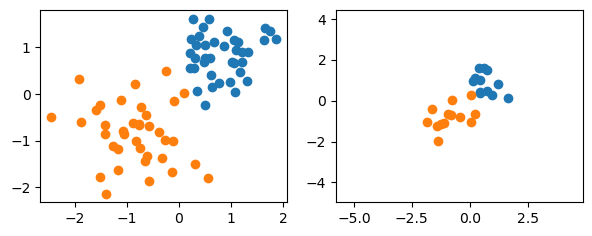

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

### Low-level implementation with manual gradients

### Load data

In [66]:
data = pd.read_csv('/nfs/team292/kt22/misc/nn_course/data/linreg-data.csv',
                   index_col = 0)
data.head(3)

,x1,x2,y
0,-2.201441,-0.468864,-30.355617
1,-0.291041,0.777277,25.560334
2,-0.327755,0.040071,32.797526


### Split data

In [67]:
X = torch.tensor(data[['x1', 'x2']].values, dtype = torch.float)
y = torch.tensor(data['y'].values, dtype = torch.float)

# -- Shuffle observations
idx = torch.randperm(y.size(0), dtype = torch.long)
X, y = X[idx], y[idx]

# -- Split train/test
cutoff = int(idx.size(0) * 0.7)

X_train, X_test = X[idx[:cutoff]], X[idx[cutoff:]]
y_train, y_test = y[idx[:cutoff]], y[idx[cutoff:]]

### Normalize data

In [68]:
mu, sigma = X_train.mean(axis = 0), X_train.std(axis = 0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

w = torch.zeros(1,
                10,
                dtype = torch.float32,
                device = device) + 1

In [70]:
def _sigmoid(z):
    return 1. / (1. + torch.exp(-z))

_sigmoid(w)

tensor([[0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
         0.7311]])

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class LogisticRegression1():
    
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(1,
                                   num_features, 
                                   dtype = torch.float32,
                                   device = device)
        self.bias = torch.zeros(1,
                                dtype = torch.float32,
                                device = device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights.t()), self.bias).view(-1) # net input
        probas = self._sigmoid(linear)
        return probas
        
    def backward(self, x, y, probas):  
        grad_loss_wrt_z = probas.view(-1) - y
        grad_loss_wrt_w = torch.mm(x.t(), grad_loss_wrt_z.view(-1, 1)).t()
        grad_loss_wrt_b = torch.sum(grad_loss_wrt_z)
        return grad_loss_wrt_w, grad_loss_wrt_b
            
    def predict_labels(self, x):
        probas = self.forward(x)
        labels = torch.where(probas >= .5, 1, 0) # threshold function
        return labels    
            
    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy
    
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba.view(-1, 1)))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba.view(-1, 1)))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate = 0.01):
        epoch_cost = []
        for e in range(num_epochs):
            
            #### Compute outputs ####
            probas = self.forward(x)
            
            #### Compute gradients ####
            grad_w, grad_b = self.backward(x, y, probas)

            #### Update weights ####
            self.weights -= learning_rate * grad_w
            self.bias -= learning_rate * grad_b
            
            #### Logging ####
            cost = self._logit_cost(y, self.forward(x)) / x.size(0)
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % cost)
            epoch_cost.append(cost)
        return epoch_cost

### PyTorch implementation

In [72]:
class LogisticRegression2(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression2, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch
        
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

model2 = LogisticRegression2(num_features = 2).to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr = 0.1)

### Define training and evaluation

In [95]:
def comp_accuracy(label_var, pred_probas):
    pred_labels = torch.where((pred_probas > 0.5), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc


num_epochs = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model2(X_train_tensor)
    
    #### Compute gradients ####
    loss = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    optimizer.zero_grad()
    loss.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model2(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))


    
print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 001 | Train ACC: 0.000 | Cost: -3122.435
Epoch: 002 | Train ACC: 0.000 | Cost: -3122.448
Epoch: 003 | Train ACC: 0.000 | Cost: -3122.460
Epoch: 004 | Train ACC: 0.000 | Cost: -3124.836
Epoch: 005 | Train ACC: 0.000 | Cost: -3120.491
Epoch: 006 | Train ACC: 0.000 | Cost: -3127.656
Epoch: 007 | Train ACC: 0.000 | Cost: -3122.346
Epoch: 008 | Train ACC: 0.000 | Cost: -3122.371
Epoch: 009 | Train ACC: 0.000 | Cost: -3122.403
Epoch: 010 | Train ACC: 0.000 | Cost: -3122.453
Epoch: 011 | Train ACC: 0.000 | Cost: -3120.490
Epoch: 012 | Train ACC: 0.000 | Cost: -3127.671
Epoch: 013 | Train ACC: 0.000 | Cost: -3121.246
Epoch: 014 | Train ACC: 0.000 | Cost: -3127.160
Epoch: 015 | Train ACC: 0.000 | Cost: -3121.083
Epoch: 016 | Train ACC: 0.000 | Cost: -3120.407
Epoch: 017 | Train ACC: 0.000 | Cost: -3127.089
Epoch: 018 | Train ACC: 0.000 | Cost: -3122.301
Epoch: 019 | Train ACC: 0.000 | Cost: -3122.324
Epoch: 020 | Train ACC: 0.000 | Cost: -3122.372
Epoch: 021 | Train ACC: 0.000 | Cost: -3

/tmp/ipykernel_53870/2909985909.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
/tmp/ipykernel_53870/2909985909.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


In [114]:
def to_onehot(y, num_classes):
    y_onehot = torch.zeros(y.size(0), num_classes)
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1).float()
    return y_onehot

y = torch.tensor([0, 1, 2, 2])

y_enc = to_onehot(y, 3)



Z = torch.tensor( [[-0.3,  -0.5, -0.5],
                   [-0.4,  -0.1, -0.5],
                   [-0.3,  -0.94, -0.5],
                   [-0.99, -0.88, -0.5]])

In [177]:
a = torch.exp(Z.t())
b = torch.sum(torch.exp(Z), dim = 1).t()
a/b

tensor([[0.3792, 0.3072, 0.4263, 0.2668],
        [0.3104, 0.4147, 0.2248, 0.2978],
        [0.3104, 0.2780, 0.3490, 0.4354]])

In [178]:
a

tensor([[0.7408, 0.6703, 0.7408, 0.3716],
        [0.6065, 0.9048, 0.3906, 0.4148],
        [0.6065, 0.6065, 0.6065, 0.6065]])

In [182]:
0.6065/b[0]

tensor(0.3104)

In [ ]:
0.3792, 0.3072, 0.4263, 0.2668

In [173]:
b.t().dim

<function Tensor.dim>

In [159]:
torch.sum(torch.exp(torch.tensor([-0.3000, -0.9400, -0.5000])))

tensor(1.7380)

In [ ]:
28 * 28

: 

In [138]:
a.t()/b

tensor([[0.3792, 0.3072, 0.4263, 0.2668],
        [0.3104, 0.4147, 0.2248, 0.2978],
        [0.3104, 0.2780, 0.3490, 0.4354]])